In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report
import pickle

In [3]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13313628262764489193
xla_global_id: -1
]


In [4]:
file_path = ("../input/color")

In [5]:
# def delete_photos_with_keyword(directory, keyword):
#     # 주어진 디렉토리 내의 파일 목록을 가져옴
#     files = os.listdir(directory)
    
#     # 파일 목록을 순회하면서 특정 키워드를 포함하는 파일을 삭제
#     for file_name in files:
#         if keyword in file_name:
#             try:
#                 file_path = os.path.join(directory, file_name)
#                 os.remove(file_path)
#                 print(f"Deleted: {file_path}")
#             except Exception as e:
#                 print(f"Failed to delete: {file_path}. Error: {e}")

# # 사용 예시
# directory_path = "../input/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus"
# keyword_to_delete = "UF.GRC_YLCV_Lab"
# delete_photos_with_keyword(directory_path, keyword_to_delete)

In [6]:
name_class = os.listdir(file_path)
name_class
label_dict = {label: index for index, label in enumerate(name_class)}

In [7]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [8]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,../input/color\Pepper___Bacterial_spot\a3d85f8...,Pepper___Bacterial_spot
1,../input/color\Tomato___healthy\583238e5-392b-...,Tomato___healthy
2,../input/color\Tomato___Early_blight\4d8cce21-...,Tomato___Early_blight
3,../input/color\Pepper___healthy\c9750f1f-48d2-...,Pepper___healthy
4,../input/color\Pepper___healthy\820f4a6b-ac2d-...,Pepper___healthy


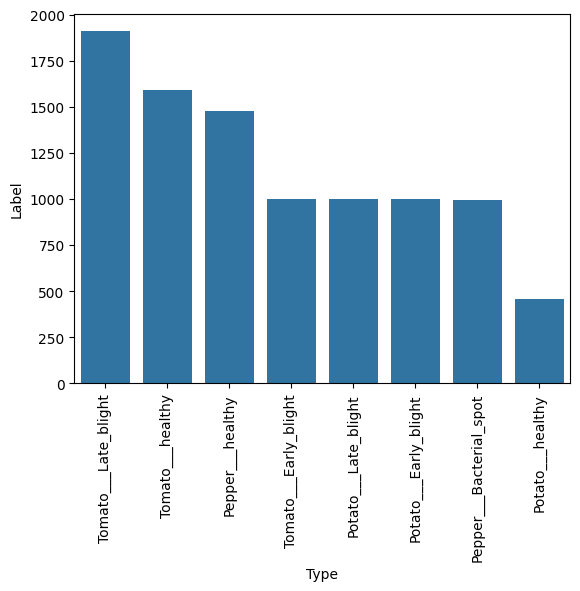

In [9]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [10]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

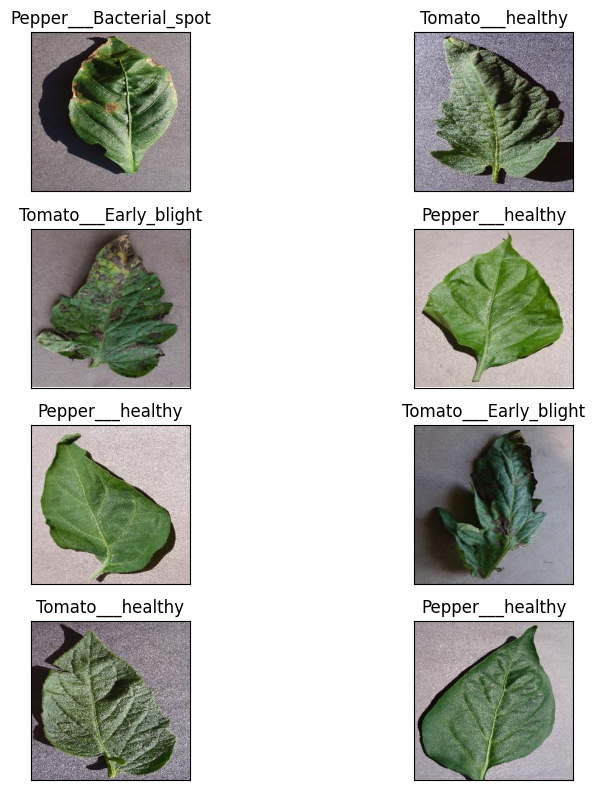

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [12]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=8,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

Found 7073 validated image filenames belonging to 8 classes.
Found 7073 validated image filenames belonging to 8 classes.
Found 2358 validated image filenames belonging to 8 classes.


In [14]:
pretrained_model = ResNet101(
    input_shape=(256,256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [15]:
inputs = pretrained_model.input

x = Dense(64, activation='relu')(pretrained_model.output)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [18]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=my_callbacks
)

Epoch 1/5


C:\users\uhyeon\appdata\local\programs\python\python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


885/885 ━━━━━━━━━━━━━━━━━━━━ 805s 899ms/step - accuracy: 0.8216 - loss: 0.5408 - val_accuracy: 0.9658 - val_loss: 0.1021
Epoch 2/5
885/885 ━━━━━━━━━━━━━━━━━━━━ 784s 886ms/step - accuracy: 0.9627 - loss: 0.1125 - val_accuracy: 0.9679 - val_loss: 0.0793
Epoch 3/5
885/885 ━━━━━━━━━━━━━━━━━━━━ 790s 893ms/step - accuracy: 0.9785 - loss: 0.0673 - val_accuracy: 0.9907 - val_loss: 0.0251
Epoch 4/5
885/885 ━━━━━━━━━━━━━━━━━━━━ 789s 891ms/step - accuracy: 0.9834 - loss: 0.0500 - val_accuracy: 0.9811 - val_loss: 0.0515
Epoch 5/5
885/885 ━━━━━━━━━━━━━━━━━━━━ 789s 892ms/step - accuracy: 0.9890 - loss: 0.0320 - val_accuracy: 0.9958 - val_loss: 0.0140


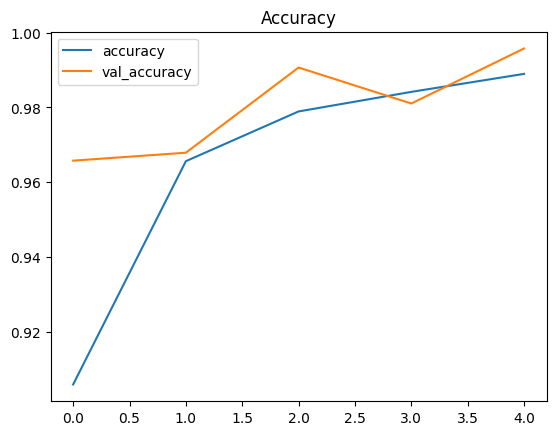

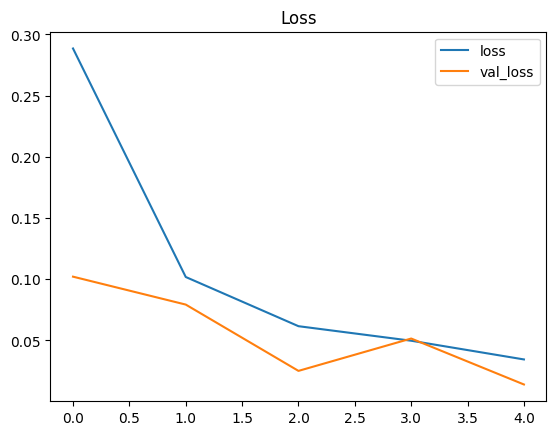

In [26]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [27]:
labels = {}
for class_name, class_index in train_gen.class_indices.items():
    labels[class_name] = class_index
with open('labels.json', 'wb') as f:
    pickle.dump(labels, f)

In [28]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.05847
Test Accuracy: 98.43%


In [22]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

295/295 ━━━━━━━━━━━━━━━━━━━━ 135s 451ms/step


In [23]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                         precision    recall  f1-score   support

Pepper___Bacterial_spot       1.00      1.00      1.00       280
       Pepper___healthy       0.98      1.00      0.99       367
  Potato___Early_blight       1.00      1.00      1.00       268
   Potato___Late_blight       0.97      0.98      0.98       233
       Potato___healthy       0.98      1.00      0.99       113
  Tomato___Early_blight       0.98      0.93      0.96       240
   Tomato___Late_blight       0.98      0.97      0.97       490
       Tomato___healthy       0.99      1.00      0.99       367

               accuracy                           0.98      2358
              macro avg       0.98      0.98      0.98      2358
           weighted avg       0.98      0.98      0.98      2358



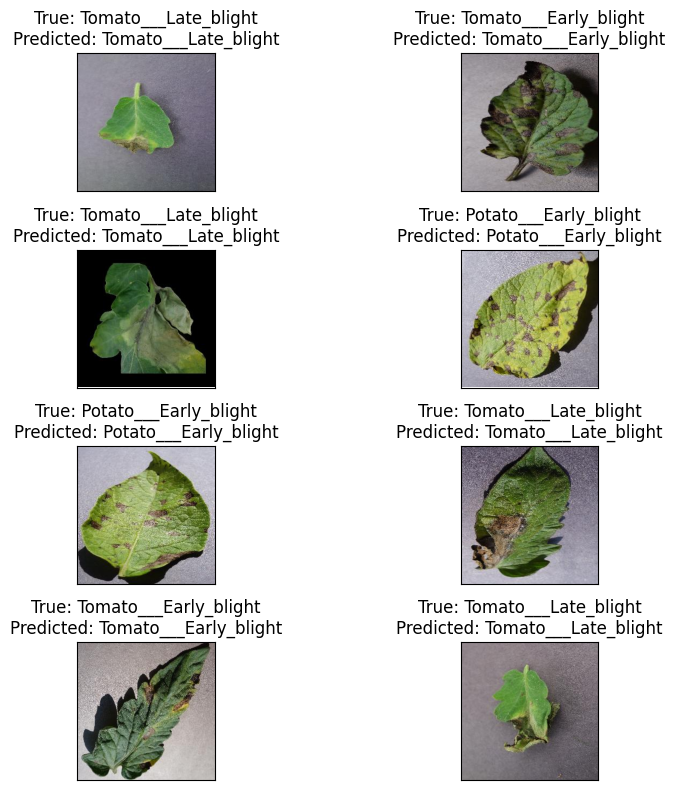

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [25]:
model.save('model.h5')